# <span style="font-weight: bolder;">Data integration for mouse brain Spatial-epigenome-transcriptome</span>
We collected the data from from AtlasXplore [Raw data](https://web.atlasxomics.com/visualization/Fan).

## <span style="font-weight: bolder;">Loading package</span>

In [1]:
from lib_3d_OT.utils import *
import scanpy as sc
import numpy as np
import pandas as pd
import torch
from lib_3d_OT.multi_modialty import *
import torch.optim as optim
import warnings
warnings.filterwarnings("ignore")

During startup - Warning messages:
1: package ‘methods’ was built under R version 4.3.2 
2: package ‘datasets’ was built under R version 4.3.2 
3: package ‘utils’ was built under R version 4.3.2 
4: package ‘grDevices’ was built under R version 4.3.2 
5: package ‘graphics’ was built under R version 4.3.2 
6: package ‘stats’ was built under R version 4.3.2 
R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



In [2]:
import os
os.environ['R_HOME'] = '/home/dbj/anaconda3/envs/r/lib/R'
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

## <span style="font-weight: bolder;">Loading  data</span>

In [3]:
adata1=sc.read_h5ad('/home/dbj/mouse/SpatialGlue/Mouse_Brain/adata_RNA.h5ad')
adata2=sc.read_h5ad('/home/dbj/mouse/SpatialGlue/Mouse_Brain/adata_peaks_normalized.h5ad')
adata1.obs['truth']=adata1.obs['RNA_clusters']
adata2.obs['truth']=adata2.obs['ATAC_clusters']
adata1.var_names_make_unique()
adata2.var_names_make_unique()

adata3=sc.read_h5ad('/home/dbj/mouse/spatialglue_alldata/Dataset9_Mouse_Brain_H3K27ac/adata_RNA.h5ad')
adata4=sc.read_h5ad('/home/dbj/mouse/spatialglue_alldata/Dataset9_Mouse_Brain_H3K27ac/adata_peaks_normalized.h5ad')
adata3.obs['truth'] = adata3.obs['RNA_clusters']
adata4.obs['truth'] = adata4.obs['H3K27ac_clusters']
adata3.var_names_make_unique()
adata4.var_names_make_unique()


## <span style="font-weight: bolder;">Pre-processing data</span>
+ 3d-OT adopts standard pre-processing steps for the transcriptomic and chromatin peak data.
+ Specifically,for the transcriptomics data,the gene expression counts are log-transformed and normalized by library size via the SCANPY package.
+ The top 3,000 highly variable genes (HVGs) are selected as input of PCA for dimension reduction. <br>
+ To ensure a consistent input dimension with the chromatin peak data, the first 50 principal components are retained and used as the input of the model.
+ For the chromatin peak data, we used LSI (latent semantic indexing) to reduce the raw chromatin peak counts data to 50 dimensions.

In [4]:
sc.pp.filter_genes(adata1, min_cells=10)
sc.pp.filter_cells(adata1, min_genes=200)
sc.pp.highly_variable_genes(adata1, flavor="seurat_v3", n_top_genes=3000)
adata1 =  adata1[:, adata1.var['highly_variable']]
sc.pp.normalize_total(adata1, target_sum=1e4)
sc.pp.log1p(adata1)
sc.pp.scale(adata1)
adata1.obsm['feat'] = pca(adata1, n_comps=50)

adata2 = adata2[adata1.obs_names].copy()
if 'X_lsi' not in adata2.obsm.keys():
    sc.pp.highly_variable_genes(adata2, flavor="seurat_v3", n_top_genes=3000)
    lsi(adata2, use_highly_variable=False, n_components=51)
adata2.obsm['feat'] = adata2.obsm['X_lsi'].copy()

sc.pp.filter_genes(adata3, min_cells=10)
sc.pp.filter_cells(adata3, min_genes=200)
adata3.obsm['spatial'] = adata3.obsm['spatial'][:, [1, 0]]
adata3.obsm['spatial'][:, 1] = -adata3.obsm['spatial'][:, 1]
sc.pp.highly_variable_genes(adata3, flavor="seurat_v3", n_top_genes=3000)
adata3 =  adata3[:, adata3.var['highly_variable']]
sc.pp.normalize_total(adata3, target_sum=1e4)
sc.pp.log1p(adata3)
sc.pp.scale(adata3)
adata3.obsm['feat'] = pca(adata3, n_comps=50)

adata4 = adata4[adata3.obs_names].copy()
adata4.obsm['spatial'] = adata3.obsm['spatial']
if 'X_lsi' not in adata4.obsm.keys():
    sc.pp.highly_variable_genes(adata4, flavor="seurat_v3", n_top_genes=3000)
    lsi(adata4, use_highly_variable=False, n_components=51)
adata4.obsm['feat'] = adata4.obsm['X_lsi'].copy()

## <span style="font-weight: bolder;">Constructing neighbor graph and training the PointNet++Encoder1</span>

In [5]:
set_seed(7)
graph1 = prepare_data(adata1, location="spatial", nb_neighbors=16).to(device)
graph2 = prepare_data(adata2, location="spatial", nb_neighbors=16).to(device)
input_dim = graph1.express.shape[-1]
hidden_dim=32
model = extractModel(input_dim,hidden_dim,n_heads=4, n_layers=3)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
start_time = time.time()
best_model1 = train_graph_extractor(graph1,graph2, model ,optimizer, device,epochs=300)

## Constructing neighbor graph and training the PointNet++Encoder2

In [6]:
graph3 = prepare_data(adata3, location="spatial", nb_neighbors=16).to(device)
graph4 = prepare_data(adata4, location="spatial", nb_neighbors=16).to(device)
input_dim = graph3.express.shape[-1]
hidden_dim=32
model2 = extractModel(input_dim,hidden_dim,n_heads=4, n_layers=3)
model2 = model2.to(device)
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)
best_model2 = train_graph_extractor(graph3,graph4, model2 ,optimizer2, device,epochs=300)

## <span style="font-weight: bolder;">Obtain the fusion feature representation of ATAC+RNA</span>

In [7]:
with torch.no_grad(): 
    MODEL=extractModel(input_dim=input_dim,hidden_dim=hidden_dim)
    MODEL.to(device)
    MODEL.load_state_dict(best_model1)
    MODEL.eval()
    recon1, recon2,mixed_modal_features = MODEL(graph1, graph2)
    mixed_modal_features = mixed_modal_features.squeeze(0) 
    gene_expression_matrix = mixed_modal_features.cpu().detach().numpy()
adata1.obsm['3d-OT']=gene_expression_matrix

## <span style="font-weight: bolder;">After integration, we perform clustering analysis using the fusion feature representation</span>

In [8]:
clustering(adata1, n_clusters=18,key='3d-OT', method='mclust',random=2024,n_comp=20)

Using 3d-OT representation for clustering...
fitting ...
  |======================================================================| 100%


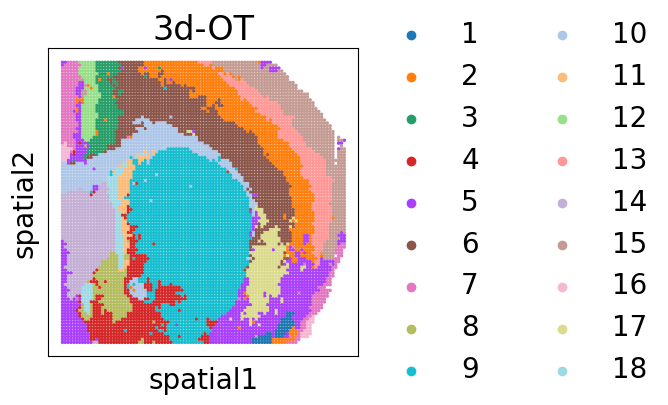

In [9]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['font.size'] = 20

fig, ax = plt.subplots()
sc.pl.embedding(adata1,basis='spatial',color='3d-OT',size=25,ax=ax)

## Calculate ARI using manual annotation 

In [10]:
adata=sc.read_h5ad('/home/dbj/mouse/spatialglue_alldata/Dataset7_Mouse_Brain_ATAC/3d-OT.h5ad')

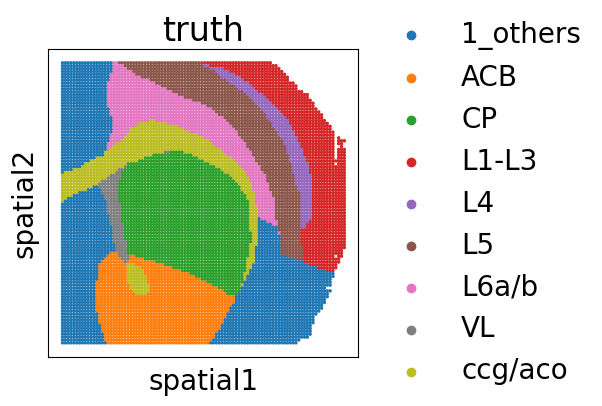

In [11]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['font.size'] = 20

fig, ax = plt.subplots()
sc.pl.embedding(adata,basis='spatial',color='truth',size=25,ax=ax)

In [12]:
import numpy as np
from sklearn.metrics import (homogeneity_score,mutual_info_score,v_measure_score,adjusted_mutual_info_score,normalized_mutual_info_score,adjusted_rand_score
)

true_labels = np.array(adata.obs['truth'])
cluster_labels = np.array(adata1.obs['3d-OT'])

homogeneity = homogeneity_score(true_labels, cluster_labels)
mutual_info = mutual_info_score(true_labels, cluster_labels)
v_measure = v_measure_score(true_labels, cluster_labels)
ami = adjusted_mutual_info_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)
ari = adjusted_rand_score(true_labels, cluster_labels)

print("Homogeneity:", homogeneity)
print("Mutual Information:", mutual_info)
print("V-Measure:", v_measure)
print("AMI:", ami)
print("NMI:", nmi)
print("ARI:", ari)

Homogeneity: 0.6730358682433512
Mutual Information: 1.3446039990672198
V-Measure: 0.5969821720866962
AMI: 0.5956272981301872
NMI: 0.5969821720866962
ARI: 0.43275843056253743


## Obtain the fusion feature representation of H3K27ac+RNA

In [11]:
with torch.no_grad(): 
    MODEL=extractModel(input_dim=input_dim,hidden_dim=hidden_dim)
    MODEL.to(device)
    MODEL.load_state_dict(best_model2)
    MODEL.eval()
    recon1, recon2,mixed_modal_features = MODEL(graph3, graph4)
    mixed_modal_features = mixed_modal_features.squeeze(0) 
    gene_expression_matrix = mixed_modal_features.cpu().detach().numpy()
adata3.obsm['3d-OT']=gene_expression_matrix

In [12]:
clustering(adata3, n_clusters=16,key='3d-OT', method='mclust',random=2024,n_comp=20)

Using 3d-OT representation for clustering...
fitting ...
  |======================================================================| 100%


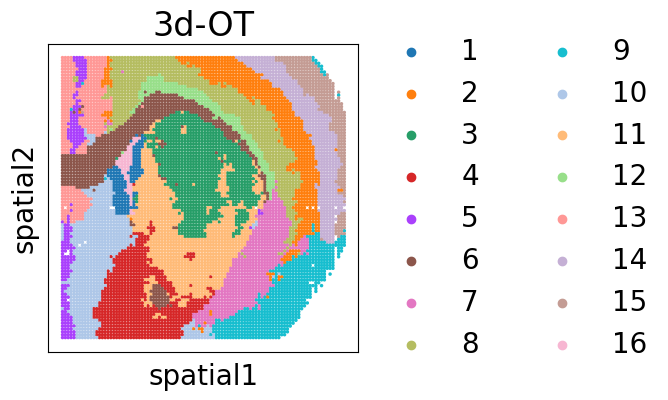

In [13]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['font.size'] = 20

fig, ax = plt.subplots()
sc.pl.embedding(adata3,basis='spatial',color='3d-OT',size=25,ax=ax)

## H3K4me3+RNA

In [ ]:
adata1=sc.read_h5ad('/home/dbj/mouse/spatialglue_alldata/Dataset8_Mouse_Brain_H3K4me3/adata_RNA.h5ad')
adata2=sc.read_h5ad('/home/dbj/mouse/spatialglue_alldata/Dataset8_Mouse_Brain_H3K4me3/adata_peaks_normalized.h5ad')
adata1.obs['truth'] = adata1.obs['RNA_clusters']
adata2.obs['truth'] = adata2.obs['H3K4me3_clusters']
adata1.var_names_make_unique()
adata2.var_names_make_unique()

In [16]:
sc.pp.filter_genes(adata1, min_cells=10)
sc.pp.filter_cells(adata1, min_genes=200)
sc.pp.highly_variable_genes(adata1, flavor="seurat_v3", n_top_genes=3000)
adata1 =  adata1[:, adata1.var['highly_variable']]
sc.pp.normalize_total(adata1, target_sum=1e4)
sc.pp.log1p(adata1)
sc.pp.scale(adata1)
adata1.obsm['feat'] = pca(adata1, n_comps=50)

adata2 = adata2[adata1.obs_names].copy()
if 'X_lsi' not in adata2.obsm.keys():
    sc.pp.highly_variable_genes(adata2, flavor="seurat_v3", n_top_genes=3000)
    lsi(adata2, use_highly_variable=False, n_components=51)
adata2.obsm['feat'] = adata2.obsm['X_lsi'].copy()

In [17]:
set_seed(7)
graph1 = prepare_data(adata1, location="spatial", nb_neighbors=16).to(device)
graph2 = prepare_data(adata2, location="spatial", nb_neighbors=16).to(device)
input_dim = graph1.express.shape[-1]
hidden_dim=32
model = extractModel(input_dim,hidden_dim,n_heads=4, n_layers=3)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
start_time = time.time()
best_model1 = train_graph_extractor(graph1,graph2, model ,optimizer, device,epochs=300)

In [18]:
with torch.no_grad(): 
    MODEL=extractModel(input_dim=input_dim,hidden_dim=hidden_dim)
    MODEL.to(device)
    MODEL.load_state_dict(best_model1)
    MODEL.eval()
    recon1, recon2,mixed_modal_features = MODEL(graph1, graph2)
    mixed_modal_features = mixed_modal_features.squeeze(0) 
    gene_expression_matrix = mixed_modal_features.cpu().detach().numpy()
adata1.obsm['3d-OT']=gene_expression_matrix

In [19]:
clustering(adata1, n_clusters=18,key='3d-OT', method='mclust',random=2024,n_comp=20)

Using 3d-OT representation for clustering...
fitting ...
  |======================================================================| 100%


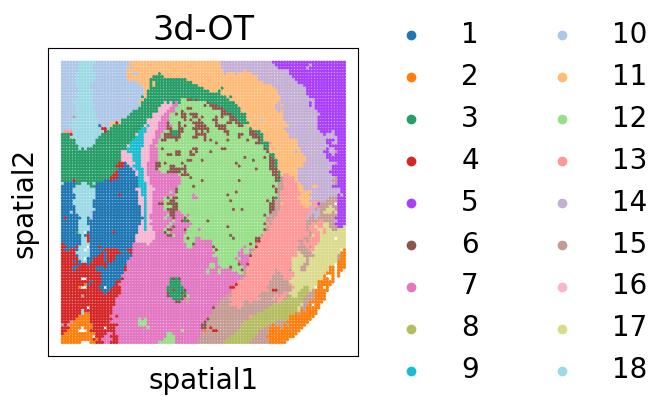

In [24]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['font.size'] = 20
adata1_rotated = copy.deepcopy(adata1)
coords = adata1_rotated.obsm['spatial']

adata1_rotated.obsm['spatial'] = np.column_stack((coords[:, 1],-coords[:, 0]))
fig, ax = plt.subplots()
sc.pl.embedding(adata1_rotated,basis='spatial',color='3d-OT',size=25,ax=ax)

## H3K27me3+RNA

In [26]:
adata1=sc.read_h5ad('/home/dbj/mouse/spatialglue_alldata/Dataset10_Mouse_Brain_H3K27me3/adata_RNA.h5ad')
adata2=sc.read_h5ad('/home/dbj/mouse/spatialglue_alldata/Dataset10_Mouse_Brain_H3K27me3/adata_peaks_normalized.h5ad')
adata1.obs['truth'] = adata1.obs['RNA_clusters']
adata2.obs['truth'] = adata2.obs['H3K27me3_clusters']
adata1.var_names_make_unique()
adata2.var_names_make_unique()

In [27]:
sc.pp.filter_genes(adata1, min_cells=10)
sc.pp.filter_cells(adata1, min_genes=200)
sc.pp.highly_variable_genes(adata1, flavor="seurat_v3", n_top_genes=3000)
adata1 =  adata1[:, adata1.var['highly_variable']]
sc.pp.normalize_total(adata1, target_sum=1e4)
sc.pp.log1p(adata1)
sc.pp.scale(adata1)
adata1.obsm['feat'] = pca(adata1, n_comps=50)

adata2 = adata2[adata1.obs_names].copy()
if 'X_lsi' not in adata2.obsm.keys():
    sc.pp.highly_variable_genes(adata2, flavor="seurat_v3", n_top_genes=3000)
    lsi(adata2, use_highly_variable=False, n_components=51)
adata2.obsm['feat'] = adata2.obsm['X_lsi'].copy()

In [32]:
set_seed(7)
graph1 = prepare_data(adata1, location="spatial", nb_neighbors=8).to(device)
graph2 = prepare_data(adata2, location="spatial", nb_neighbors=8).to(device)
input_dim = graph1.express.shape[-1]
hidden_dim=32
model = extractModel(input_dim,hidden_dim,n_heads=4, n_layers=3)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
start_time = time.time()
best_model1 = train_graph_extractor(graph1,graph2, model ,optimizer, device,epochs=500)

In [33]:
with torch.no_grad(): 
    MODEL=extractModel(input_dim=input_dim,hidden_dim=hidden_dim)
    MODEL.to(device)
    MODEL.load_state_dict(best_model1)
    MODEL.eval()
    recon1, recon2,mixed_modal_features = MODEL(graph1, graph2)
    mixed_modal_features = mixed_modal_features.squeeze(0) 
    gene_expression_matrix = mixed_modal_features.cpu().detach().numpy()
adata1.obsm['3d-OT']=gene_expression_matrix

In [34]:
clustering(adata1, n_clusters=18,key='3d-OT', method='mclust',random=2024,n_comp=20)

Using 3d-OT representation for clustering...
fitting ...
  |======================================================================| 100%


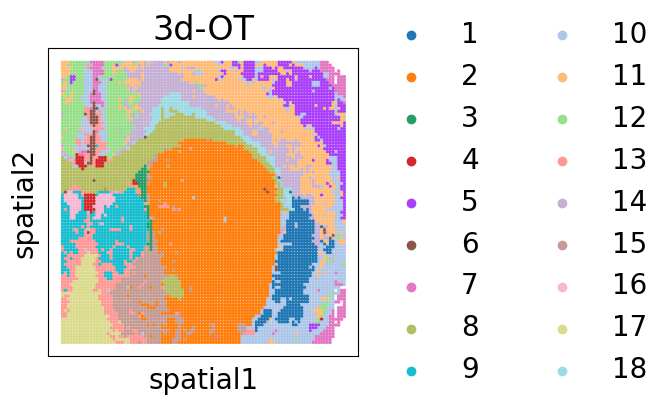

In [39]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['font.size'] = 20

fig, ax = plt.subplots()
sc.pl.embedding(adata1,basis='spatial',color='3d-OT',size=25,ax=ax)